Importing Libraries

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import drive 
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

Loading Data and Splitting in 1,74,25 order

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Labeled Train Set: (146, 24) (146,)
Unlabeled Train Set: (10830, 24) (10830,)
Test Set: (3659, 24) (3659,)


(array([106.,  40.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

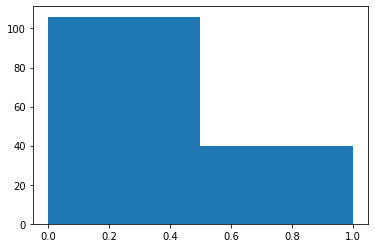

In [39]:
drive.mount('/content/gdrive')

# define dataset

df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Surgical.csv')
df = df.sample(frac=1, random_state=15).reset_index(drop=True)
# Generate indices for splits

test_ind = round(len(df)*0.25)
train_ind = test_ind + round(len(df)*0.01)
unlabeled_ind = train_ind + round(len(df)*0.74)


# Partition the data

test = df.iloc[:test_ind]
train = df.iloc[test_ind:train_ind]
unlabeled = df.iloc[train_ind:unlabeled_ind]


# Assign data to train, test, and unlabeled sets

X_train = train.drop('complication', axis=1)
y_train = train.complication

X_unlabeled = unlabeled.drop('complication', axis=1)
y_unlabeled = unlabeled.complication

X_test = test.drop('complication', axis=1)
y_test = test.complication
# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlabeled.shape, y_unlabeled.shape)
# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

plt.hist(y_train, bins = 2)


Supervised Logestic Regression

In [10]:
# define model
model = LogisticRegression(max_iter=1000)
# fit model on labeled dataset
model.fit(X_train, y_train)
# make predictions on hold out test set
yhat = model.predict(X_test)
# calculate score for test set
score = accuracy_score(y_test, yhat)
# summarize score
print('Accuracy: %.3f' % (score*100))
print (confusion_matrix(y_test, yhat))
print ('F1-score (macro): %.3f' % f1_score(y_test, yhat, average='macro'))

Accuracy: 78.163
[[2553  196]
 [ 603  307]]
F1-score (macro): 0.650


Semi-Supervised learning using logestic regression and unlabeled data

P = 99

Iteration 0
Train f1: 0.5846153846153846
Test f1: 0.5005820721769499
42 high-probability added
10788 unlabeled remaining.

Iteration 1
Train f1: 0.7627118644067796
Test f1: 0.5037463976945246
30 high-probability added
10758 unlabeled remaining.

Iteration 2
Train f1: 0.8181818181818182
Test f1: 0.5062857142857143
20 high-probability added
10738 unlabeled remaining.

Iteration 3
Train f1: 0.847457627118644
Test f1: 0.5076835515082526
21 high-probability added
10717 unlabeled remaining.

Iteration 4
Train f1: 0.8615384615384616
Test f1: 0.5102040816326531
22 high-probability added
10695 unlabeled remaining.

Iteration 5
Train f1: 0.8682926829268294
Test f1: 0.5090497737556561
24 high-probability added
10671 unlabeled remaining.

Iteration 6
Train f1: 0.8744186046511628
Test f1: 0.5090293453724605
15 high-probability added
10656 unlabeled remaining.

Iteration 7
Train f1: 0.88
Test f1: 0.5103991006183248
23 high-probability added
10633 unlabeled remaining.

Iteration 8
Train f1: 0.8879668

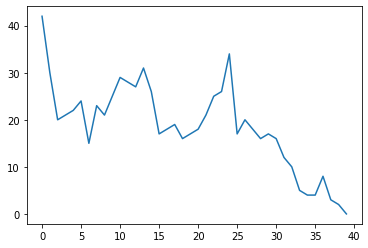

In [40]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0: #criteria
        
    # Fit classifier and make train/test predictions
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat_test = clf.predict(X_test)
    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print('Iteration', iterations)
    print('Train f1:', train_f1)
    print('Test f1:', test_f1)
    test_f1s.append(test_f1)

   
    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 99% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability added")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled remaining.\n")
    
    # Update iteration counter
    iterations += 1

plt.plot(range(iterations),pseudo_labels)

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)
print('Iteration', iterations)
print('Train f1:', train_f1)
print('Test f1:', test_f1)

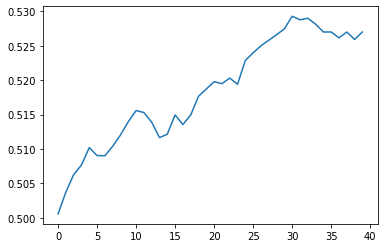

In [41]:
plt.plot(range(iterations),test_f1s)

P = 89

In [30]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0: #criteria
        
    # Fit classifier and make train/test predictions
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat_test = clf.predict(X_test)
    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print('Iteration', iterations)
    print('Train f1:', train_f1)
    print('Test f1:', test_f1)
   
    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 99% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.89],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.89]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability added")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled remaining.\n")
    
    # Update iteration counter
    iterations += 1

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)
print('Iteration', iterations)
print('Train f1:', train_f1)
print('Test f1:', test_f1)

Iteration 0
Train f1: 0.4
Test f1: 0.2977038796516231
5748 high-probability added
5082 unlabeled remaining.

Iteration 1
Train f1: 0.8947368421052632
Test f1: 0.3219438116932422
2813 high-probability added
2269 unlabeled remaining.

Iteration 2
Train f1: 0.9745958429561201
Test f1: 0.31513260530421217
927 high-probability added
1342 unlabeled remaining.

Iteration 3
Train f1: 0.9832303618711387
Test f1: 0.3012820512820513
329 high-probability added
1013 unlabeled remaining.

Iteration 4
Train f1: 0.9830795262267344
Test f1: 0.2920065252854812
146 high-probability added
867 unlabeled remaining.

Iteration 5
Train f1: 0.9831081081081082
Test f1: 0.2838283828382838
58 high-probability added
809 unlabeled remaining.

Iteration 6
Train f1: 0.9831081081081082
Test f1: 0.2838174273858921
30 high-probability added
779 unlabeled remaining.

Iteration 7
Train f1: 0.9839391377852916
Test f1: 0.2826267664172901
21 high-probability added
758 unlabeled remaining.

Iteration 8
Train f1: 0.98393913778

P = 79

In [31]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0: #criteria
        
    # Fit classifier and make train/test predictions
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat_test = clf.predict(X_test)
    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print('Iteration', iterations)
    print('Train f1:', train_f1)
    print('Test f1:', test_f1)
   
    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 99% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.79],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.79]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability added")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled remaining.\n")
    
    # Update iteration counter
    iterations += 1

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)
print('Iteration', iterations)
print('Train f1:', train_f1)
print('Test f1:', test_f1)

Iteration 0
Train f1: 0.9840201850294366
Test f1: 0.2804674457429049
241 high-probability added
461 unlabeled remaining.

Iteration 1
Train f1: 0.9843505477308294
Test f1: 0.27922624053826745
78 high-probability added
383 unlabeled remaining.

Iteration 2
Train f1: 0.9844236760124611
Test f1: 0.2751054852320675
37 high-probability added
346 unlabeled remaining.

Iteration 3
Train f1: 0.9836575875486381
Test f1: 0.27218934911242604
16 high-probability added
330 unlabeled remaining.

Iteration 4
Train f1: 0.9836829836829836
Test f1: 0.270956816257409
1 high-probability added
329 unlabeled remaining.

Iteration 5
Train f1: 0.9836829836829836
Test f1: 0.270956816257409
1 high-probability added
328 unlabeled remaining.

Iteration 6
Train f1: 0.9836829836829836
Test f1: 0.270956816257409
2 high-probability added
326 unlabeled remaining.

Iteration 7
Train f1: 0.9836829836829836
Test f1: 0.2677966101694915
4 high-probability added
322 unlabeled remaining.

Iteration 8
Train f1: 0.983682983682